In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import os
from ctd.comparison.analysis.tt.tasks.tt_MultiTask import Analysis_TT_MultiTask 
# Import pca
from sklearn.decomposition import PCA
import glob
import cv2
import shutil
import imageio
import math

In [2]:

suffix = "MultiTaskNoisyGRU"
filepath1 = (
"/home/csverst/Github/CtDBenchmark/content/trained_models/task-trained/20240510_MultiTask_GRU_RNN_Final/max_epochs=500 n_samples=2000 batch_size=64 latent_size=128 seed=0 learning_rate=0.0008/"
)
plot_path = (
    "/home/csverst/Github/InterpretabilityBenchmark/"
    f"interpretability/comparison/plots/{suffix}/"
)
os.makedirs(plot_path, exist_ok=True)


phase_plot = "mem1"
phase_for_pca = "mem1"
task_to_analyze = "MemoryPro"
task_for_pca = "MemoryPro"
plot_fps = True
comp = Analysis_TT_MultiTask(run_name=suffix, filepath=filepath1)
    
# Get the model outputs
ics, inputs, targets = comp.get_model_inputs_noiseless()
out_dict = comp.get_model_outputs_noiseless()
lats = out_dict["latents"]
outputs = out_dict["controlled"]

phases = comp.datamodule.extra_data["phase_dict"]
# Get the full trial latents in the phase PCA space

In [3]:

def angle_diff(angle1, angle2):
    """
    Calculate the smallest angle between two angles in radians, handling the wrap around at theta = 0.
    
    Parameters:
    angle1 (float): First angle in radians.
    angle2 (float): Second angle in radians.
    
    Returns:
    float: The smallest angle between the two angles in radians.
    """
    # Normalize angles to the range [0, 2*pi)
    angle1 = angle1 % (2 * math.pi)
    angle2 = angle2 % (2 * math.pi)
    
    # Calculate the difference
    diff = abs(angle1 - angle2)
    
    # Ensure the difference is the smallest possible angle
    if diff > math.pi:
        diff = 2 * math.pi - diff
        
    return diff

Trial1: ang:1.365929365158081 mag:0.9728785753250122


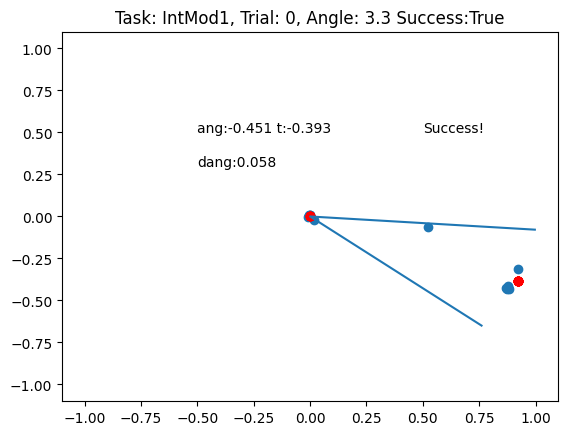

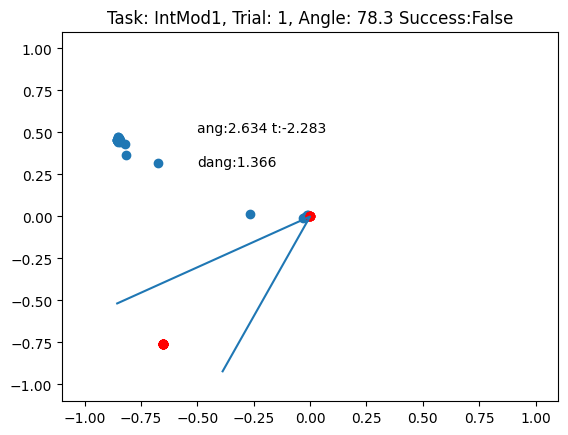

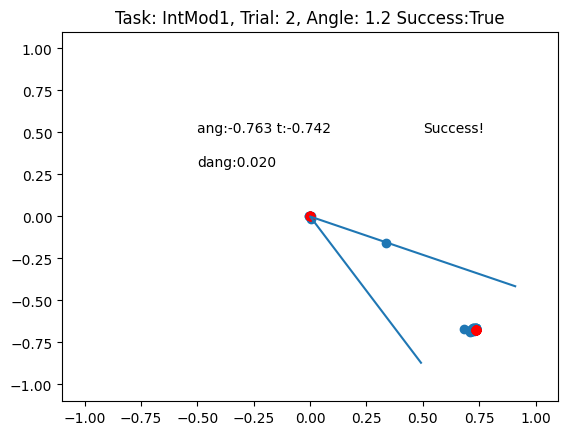

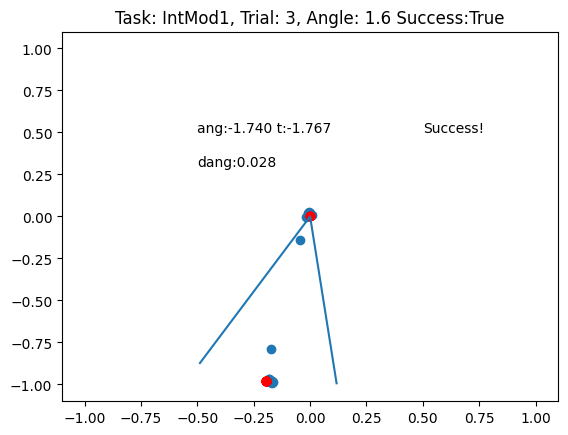

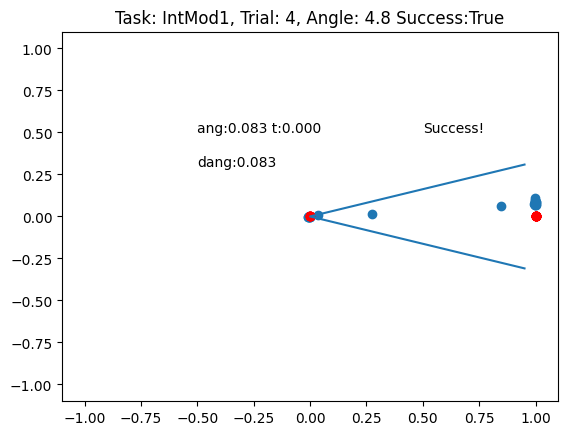

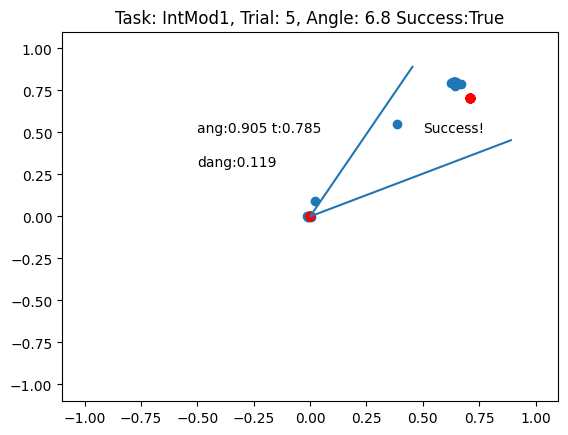

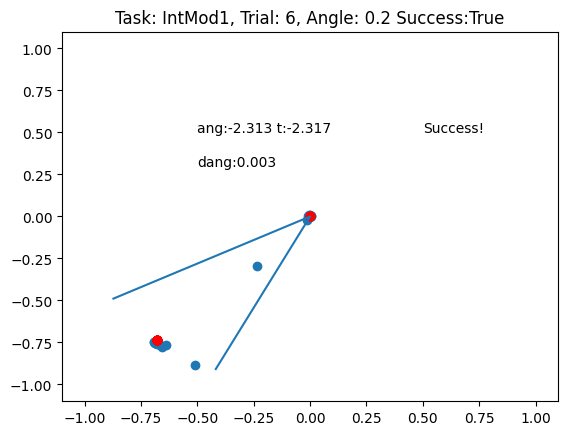

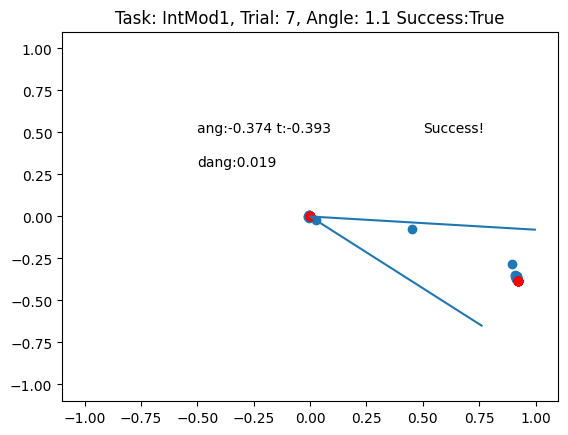

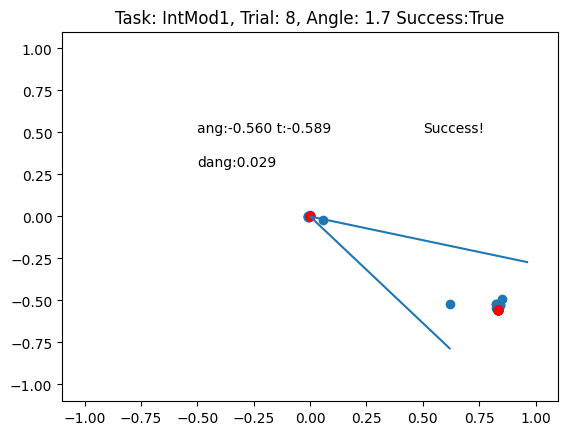

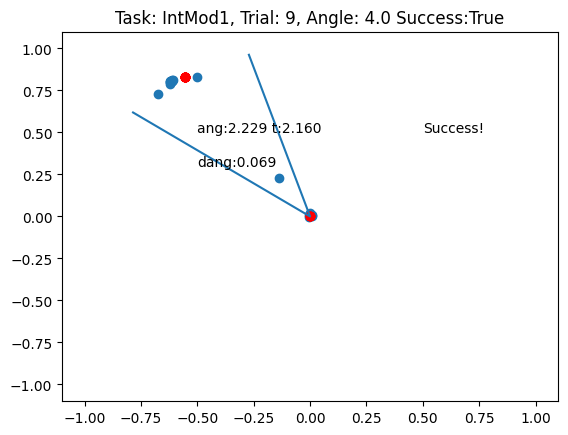

In [4]:
task_to_analyze = "IntMod1"
num_trials = 10
plot_trials = True


dataloader = comp.datamodule.val_dataloader()
pl_module =comp.wrapper
ics = torch.cat([batch[0] for batch in dataloader]).to(pl_module.device)
inputs = torch.cat([batch[1] for batch in dataloader]).to(pl_module.device)
targets = (
    torch.cat([batch[2] for batch in dataloader])
    .to(pl_module.device)
    .detach()
    .cpu()
    .numpy()
)
inds = (
    torch.cat([batch[3] for batch in dataloader])
    .to(pl_module.device)
    .detach()
    .cpu()
    .numpy()
    .astype(int)
)

output_dict = pl_module.forward(ics, inputs)

extra_dict = comp.datamodule.extra_data
phase_dict = [extra_dict["phase_dict"][ind] for ind in inds]
task_names = [extra_dict["task_names"][ind] for ind in inds]
task_inds = [
        i for i, task in enumerate(task_names) if task == task_to_analyze
    ]
task_inputs = torch.Tensor(inputs[task_inds]).to(pl_module.device)
task_ics = torch.Tensor(ics[task_inds]).to(pl_module.device)
task_targets = torch.Tensor(targets[task_inds])
task_phase_dict = [
    dict1 for i, dict1 in enumerate(phase_dict) if i in task_inds
]

# Pass data through the model
output_dict = pl_module.forward(task_ics, task_inputs)
tt_outputs = output_dict["controlled"].detach().numpy()
trial_success = []
for i in range(num_trials):

    trial_phases = task_phase_dict[i]

    resp_start = trial_phases['response'][0] 
    resp_end = trial_phases['response'][1]
    resp_len = resp_end- resp_start
    response_val = tt_outputs[
            i,
            resp_end-1 : resp_end,
            1:,
        ]
    mean_response = np.mean(response_val, axis=0)
    mean_angle = np.arctan2(mean_response[1], mean_response[0])
    targ_val = task_targets[i, resp_end-1, 1:]
    targ_angle = np.arctan2(task_targets[i, resp_end-1, 2], task_targets[i, resp_end-1, 1])
    dAngle = angle_diff(mean_angle, targ_angle)

    if np.linalg.norm(mean_response) < 0.2:
        stays = True
    else:
        stays = False
    if np.linalg.norm(targ_val) < 0.2:
        no_response = True
    else:
        no_response = False
    
    if no_response and stays:
        success = True
    elif not no_response and dAngle < np.pi/10:
        success = True
    else:
        success = False
    trial_success.append(success)
    if plot_trials:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(tt_outputs[i, resp_start-5:resp_end,1], tt_outputs[i, resp_start-5:resp_end, 2])
        ax.scatter(task_targets[i, resp_start-5:resp_end,1], task_targets[i, resp_start-5:resp_end, 2], c = 'r')
        correct_line_X = [np.cos(targ_angle + np.pi/10), 0, np.cos(targ_angle -np.pi/10)]
        correct_line_Y = [np.sin(targ_angle + np.pi/10), 0, np.sin(targ_angle -np.pi/10)]
        if not no_response:
            ax.plot(correct_line_X, correct_line_Y)
            ax.set_title(f"Task: {task_to_analyze}, Trial: {i}, Angle: {np.rad2deg(dAngle):.1f} Success:{success}")
            ax.text(-0.5, 0.5, s = f"ang:{mean_angle:.3f} t:{targ_angle:.3f}")
            ax.text(-0.5, 0.3, s = f"dang:{dAngle:.3f}")
            
        else:
            # Plot a circle
            circle1 = plt.Circle((0,0), radius = 0.2, fill=False)

            ax.add_patch(circle1)
            ax.set_title(f"Task: {task_to_analyze}, Trial: {i}, Mag: {np.linalg.norm(mean_response):.1f} Success:{success}")
        ax.set_xlim(-1.1,1.1)
        ax.set_ylim(-1.1,1.1)
        if success:
            ax.text(0.5, 0.5, s = "Success!")
        else:
            print(f'Trial{i}: ang:{dAngle} mag:{np.linalg.norm(mean_response)}')
    # Set axes square



In [5]:
success_pct = np.sum(trial_success)/ len(trial_success)
print(success_pct)

0.9


In [6]:

# Get the data from the datamodule
dataloader = comp.datamodule.val_dataloader()
pl_module = comp.wrapper
trainer = comp
ics = torch.cat([batch[0] for batch in dataloader]).to(pl_module.device)
inputs = torch.cat([batch[1] for batch in dataloader]).to(pl_module.device)
targets = (
    torch.cat([batch[2] for batch in dataloader])
    .to(pl_module.device)
    .detach()
    .cpu()
    .numpy()
)
inds = (
    torch.cat([batch[3] for batch in dataloader])
    .to(pl_module.device)
    .detach()
    .cpu()
    .numpy()
    .astype(int)
)
output_dict = pl_module.forward(ics, inputs)

extra_dict = trainer.datamodule.extra_data
phase_dict = [extra_dict["phase_dict"][ind] for ind in inds]
task_names = [extra_dict["task_names"][ind] for ind in inds]

percent_success = np.zeros(len(trainer.datamodule.data_env.task_list_str))
task_success = {}
unique_tasks = np.unique(task_names)
# find indices where task_to_analyze is the task
for task_num, task_to_analyze in enumerate(unique_tasks):
    task_inds = [
        i for i, task in enumerate(task_names) if task == task_to_analyze
    ]

    # Get the inputs, ics, and phase_dict for the task
    task_inputs = torch.Tensor(inputs[task_inds]).to(pl_module.device)
    task_ics = torch.Tensor(ics[task_inds]).to(pl_module.device)
    task_targets = torch.Tensor(targets[task_inds])
    task_phase_dict = [
        dict1 for i, dict1 in enumerate(phase_dict) if i in task_inds
    ]

    # Pass data through the model
    output_dict = pl_module.forward(task_ics, task_inputs)
    tt_outputs = output_dict["controlled"]

    tt_outputs = tt_outputs.detach().cpu()
    task_targets = task_targets.detach().cpu()

    perf = np.zeros(len(task_phase_dict))
    perf_dist = np.ones(len(task_phase_dict))
    no_respond_trial = np.zeros(len(task_phase_dict), dtype=bool)

    # Iterate through task trials
    for i in range(len(task_phase_dict)):
        response_edges = task_phase_dict[i]["response"]
        response_len = response_edges[1] - response_edges[0]

        # Compute average angle for the last 1/8 of the response period
        response_val = tt_outputs[
            i,
            response_edges[0] + (7 * response_len // 8) : response_edges[1],
            1:,
        ]
        mean_response = torch.mean(response_val, dim=0)
        mean_angle = torch.atan2(mean_response[1], mean_response[0])

        # Get the target angle
        response_target = task_targets[
            i, response_edges[1]-1, 1:
        ]
        mean_target_angle = torch.atan2(response_target[1], response_target[0])

        # Compute the performance (angle difference)
        perf[i] = angle_diff(mean_angle, mean_target_angle)

        # if no response was correct, check if the response was close to 0
        if torch.sum(np.abs(response_target)) == 0:
            no_respond_trial[i] = True
            perf_dist[i] = torch.sum(mean_response)

    # Compute the percent success (angle < pi/10)
    flag_success_angle = perf < (np.pi /10)
    flag_success_noreport = np.logical_and(perf_dist < 0.2, no_respond_trial)
    flag_success = np.logical_or(flag_success_angle, flag_success_noreport)
    percent_success = np.sum(flag_success) / len(flag_success)
    task_success[task_to_analyze] = percent_success


In [7]:
for key, val in task_success.items():
    print(f"{key}: % success: {val}")

ContextIntMod1: % success: 0.9418604651162791
ContextIntMod2: % success: 0.9333333333333333
ContextIntMultimodal: % success: 0.8865979381443299
DelayAnti: % success: 1.0
DelayPro: % success: 1.0
IntMod1: % success: 0.93
IntMod2: % success: 0.8907563025210085
Match2Sample: % success: 0.9714285714285714
MatchCatAnti: % success: 0.9807692307692307
MatchCatPro: % success: 0.9705882352941176
MemoryAnti: % success: 1.0
MemoryPro: % success: 0.9893617021276596
NonMatch2Sample: % success: 0.9811320754716981
ReactAnti: % success: 1.0
ReactPro: % success: 1.0
